In [1]:
import pandas as pd
from database.market import Market
from datetime import datetime,timedelta
from parameters.parameters import Parameters
from backtester.backtester_lite import BacktesterLite
from processor.processor import Processor as p
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
market = Market()

In [3]:
market.connect()
sp500 = market.retrieve("sp500").rename(columns={"Symbol":"ticker"})
market.disconnect()

In [4]:
start_date = datetime(2001,1,1)
end_date = datetime(2020,1,1)
lookbacks = [5,20,60]
positions = 20

In [5]:
parameters = Parameters.parameters_lite(lookbacks)

In [6]:
len(parameters)

12

In [7]:
simulation = []
market.connect()
for ticker in tqdm(sp500["ticker"]):
    try:
        ticker_data = market.retrieve_ticker_prices("stocks",ticker)
        ticker_data = p.column_date_processing(ticker_data)
        ticker_data.sort_values("date",inplace=True)
        ticker_data = ticker_data[["date","ticker","adjclose"]]
        ticker_data["prev_close"] = ticker_data["adjclose"].shift(1)
        for lookback in lookbacks:
            ticker_data[f"window_{lookback}"] = ticker_data["prev_close"].shift(lookback)
            ticker_data[f"rolling_{lookback}"] = ticker_data["prev_close"].rolling(lookback).mean()
        ticker_data[f"return"] = (ticker_data["adjclose"].shift(-1) - ticker_data["adjclose"]) / ticker_data["adjclose"]
        simulation.append(ticker_data.dropna())
    except Exception as e:
        print(ticker,str(e))
market.disconnect()
final = pd.concat(simulation)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 490/490 [00:36<00:00, 13.53it/s]


In [8]:
final

,date,ticker,adjclose,prev_close,window_5,rolling_5,window_20,rolling_20,window_60,rolling_60,return
61,2000-03-30,MMM,24.209033,23.836377,23.392998,24.101317,23.428360,23.278617,25.512158,24.437092,-0.004944
62,2000-03-31,MMM,24.089348,24.209033,23.665010,24.210121,23.409319,23.318603,24.498484,24.432268,0.037489
63,2000-04-03,MMM,24.992427,24.089348,24.720415,24.083908,24.345039,23.305819,25.747331,24.404635,0.011537
64,2000-04-04,MMM,25.280759,24.992427,24.108389,24.260715,23.733013,23.368789,27.247569,24.367049,-0.019475
65,2000-04-05,MMM,24.788418,25.280759,24.176392,24.481589,22.508961,23.507379,27.788195,24.325258,0.024690
...,...,...,...,...,...,...,...,...,...,...,...
2641,2023-08-01,ZTS,185.510000,188.090000,185.580000,189.766000,172.210000,176.604218,177.730000,173.947906,-0.018921
2642,2023-08-02,ZTS,182.000000,185.510000,190.150000,188.838000,170.230000,177.368218,178.470000,174.065239,-0.006154
2643,2023-08-03,ZTS,180.880000,182.000000,192.000000,186.838000,169.350000,178.000718,186.230000,173.994739,-0.012439
2644,2023-08-04,ZTS,178.630000,180.880000,188.690000,185.276000,168.470000,178.621218,184.870000,173.928239,0.011532


In [22]:
all_trades = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        trades = BacktesterLite.backtest(positions,final.copy(),iteration,parameter,False)
        all_trades.append(trades)
    except Exception as e:
        print(str(e))

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:36<00:00,  3.03s/it]


In [10]:
analysis = pd.concat(all_trades)
analysis["return"] = analysis["return"] + 1

In [11]:
report = []
for iteration in tqdm(range(len(parameters))):
    try:
        parameter = parameters[iteration]
        iteration_trades = analysis[analysis["iteration"]==iteration]
        iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
        cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
        for i in range(positions):
            if float(i) not in cumulative.columns:
                cumulative[float(i)] = 1
        cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
        iter_report = cumulative.cumprod().iloc[-1]
        for key in parameter.keys():
            iter_report[key] = parameter[key]
        iter_report["iteration"] = iteration
        report.append(iter_report[["pv","iteration"] + list(parameter.keys())])
    except Exception as e:
        print(str(e))
        continue

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 12/12 [00:01<00:00, 11.95it/s]

single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds
single positional indexer is out-of-bounds


In [18]:
performance = pd.DataFrame(report)

In [19]:
performance.sort_values("pv",ascending=False).head(20)

position,pv,iteration,strategy,value,lookback
4778,368.015395,1,rolling,True,20
4778,343.104095,0,rolling,True,5


In [20]:
iteration = performance.sort_values("pv",ascending=False).iloc[0]["iteration"]
parameter = parameters[iteration]
iteration_trades = analysis[analysis["iteration"]==iteration]
iteration_trades = iteration_trades[(iteration_trades["date"]>=start_date) & (iteration_trades["date"]<=end_date)]
cumulative = iteration_trades.pivot_table(values="return",index="date",columns="position").reset_index()
cumulative["pv"] = [sum([row[1][float(x)] * float(1/positions) for x in range(positions)]) for row in cumulative.iterrows()]
cumulative["pv"] = cumulative["pv"].cumprod()

In [21]:
cumulative

position,date,0,1,2,3,4,5,6,7,8,...,11,12,13,14,15,16,17,18,19,pv
0,2001-01-02,1.102061,1.239889,1.084913,1.077517,1.016854,1.026103,1.105118,1.068034,1.240168,...,1.170114,1.306947,1.304158,0.905574,1.265130,1.283688,1.089565,1.227848,1.268293,1.128429
1,2001-01-03,0.898882,1.042992,1.071823,1.035330,0.877551,0.939091,0.949242,1.115001,1.023172,...,1.013798,0.927684,0.921757,0.877893,1.000000,0.953728,0.882688,0.861031,1.134615,1.103605
2,2001-01-04,0.822989,0.874642,0.981447,0.958140,0.895031,0.896390,0.939355,0.916098,0.922266,...,0.974524,0.931034,1.085455,0.938835,0.879457,1.104972,0.845011,0.792542,0.959070,1.022697
3,2001-01-05,1.022611,1.013071,1.006646,1.016729,0.962330,1.007035,1.026212,1.031998,0.962144,...,0.924722,1.026099,0.925212,0.958333,1.022605,0.985000,0.986600,0.743300,1.163919,1.001091
4,2001-01-08,0.923514,1.047689,1.015869,1.005044,1.100413,0.944162,0.998864,0.916160,0.941851,...,1.096386,1.021277,1.036667,0.994115,1.103596,1.040703,0.956140,0.971831,0.927500,1.006107
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4774,2019-12-24,0.998859,0.990751,1.004912,1.005400,1.003602,0.988457,0.996429,1.011341,0.971071,...,1.002613,0.986441,0.997660,0.996201,0.991348,1.003779,0.992513,1.009513,1.001913,365.890515
4775,2019-12-26,1.000827,0.998114,1.004404,1.001142,0.997947,1.014663,0.999643,1.005629,1.004467,...,1.000262,1.000667,1.006449,1.023646,1.009965,0.989825,1.008394,0.991736,0.992924,366.803415
4776,2019-12-27,0.985784,1.004231,1.001236,0.984331,0.997159,0.993387,0.993196,1.006501,0.997897,...,0.988671,0.985825,0.996153,0.997016,0.976155,1.001539,1.008795,0.988303,0.989027,364.919871
4777,2019-12-30,1.000000,1.007502,1.005313,1.007127,0.998890,1.009423,1.008397,1.004214,1.003806,...,1.016226,1.000897,1.008516,0.998039,1.005100,0.991709,1.019726,1.000459,1.002745,366.737822


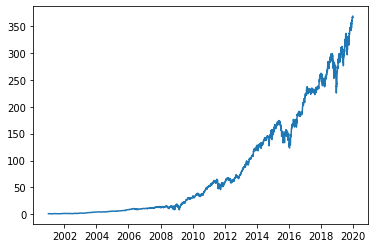

In [16]:
plt.plot(cumulative["date"],cumulative["pv"])

In [17]:
parameter

{'strategy': 'rolling', 'value': True, 'lookback': 20}